# Train

Epoch 0/14
--------------------
Training IMU
Epoch loss average: 0.3987
----------
Testing model
Test loss average: 0.4604
----------
Time per epoch: 96.19813
Epoch 1/14
--------------------
Training IMU
Epoch loss average: 0.3903
----------
Testing model
Test loss average: 0.4413
----------
Time per epoch: 92.66812
Epoch 2/14
--------------------
Training IMU
Epoch loss average: 0.3896
----------
Testing model
Test loss average: 0.4509
----------
Time per epoch: 94.34215
Epoch 3/14
--------------------
Training IMU
Epoch loss average: 0.3896
----------
Testing model
Test loss average: 0.4418
----------
Time per epoch: 92.89792
Epoch 4/14
--------------------
Training IMU
Epoch loss average: 0.3896
----------
Testing model
Test loss average: 0.4486
----------
Time per epoch: 91.65406
Epoch 5/14
--------------------
Training IMU
Epoch loss average: 0.3895
----------
Testing model
Test loss average: 0.4483
----------
Time per epoch: 86.78387
Epoch 6/14
--------------------
Training IMU
E

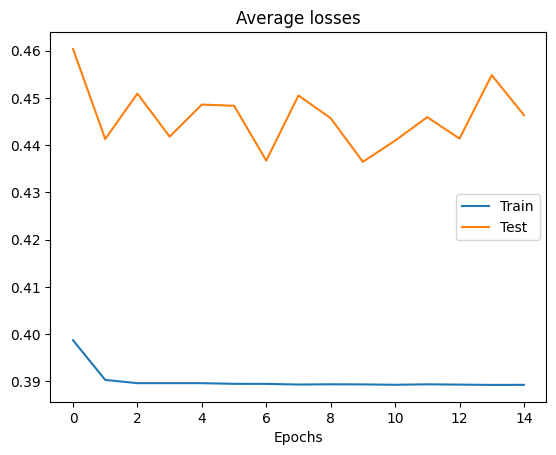

In [6]:
import torch
torch.set_printoptions(precision=20)
torch.set_default_dtype(torch.float64)
from torch import nn
from os import path
from RosbagDatasets import ROSbagIMUGT
from torch.utils.data import ConcatDataset
import time
from matplotlib import pyplot as plt
import numpy as np
import pickle

OUTPUT_DIR = './outputs/'
NUM_EPOCHS = 15
MINIBATCH_SIZE = 16
IMU_SEQUENCE_LENGTH = 16
HIDDEN_SIZE = 6
NORMALIZE_DATA = True


class MinMaxNormalizer:
    def __init__(self, feature_range=(-1, 1)):
        self.transform_dict = None
        self.feature_range = feature_range

    def fit_transform(self, datasets):
        # loop through datasets and determine global min and max value per feature
        rawdata = np.concatenate([dset.imudata for dset in datasets.datasets])
        imu_dmax = rawdata.max(axis=0)
        imu_dmin = rawdata.min(axis=0)

        rawdata = np.concatenate([dset.d_gt_dist_angle_items for dset in datasets.datasets])
        distangle_dmax = rawdata.max(axis=0)
        distangle_dmin = rawdata.min(axis=0)

        rawdata = np.concatenate([dset.delta_yaw_items for dset in datasets.datasets])
        deltayaw_dmax = rawdata.max()
        deltayaw_dmin = rawdata.min()

        self.transform_dict = {'imudata': [imu_dmin, imu_dmax],
                               'dist_angle': [distangle_dmin, distangle_dmax],
                               'delta_yaw': [deltayaw_dmin, deltayaw_dmax]}

    def transform(self, data):
        data['imudata'] = self.__apply_transform__(data['imudata'], self.transform_dict['imudata'])
        data['d_gt_dist_angle'] = self.__apply_transform__(data['d_gt_dist_angle'], self.transform_dict['dist_angle'])
        data['delta_yaw'] = self.__apply_transform__(data['delta_yaw'], self.transform_dict['delta_yaw'])

        return data

    # undoes transformation (assumes torch tensor input)
    def inverse_transform(self, datascaled, dminmax):
        data = torch.tensor((dminmax[1] - dminmax[0]), device=datascaled.device) * (datascaled - self.feature_range[0]) / (self.feature_range[1] - self.feature_range[0]) \
               + torch.tensor(dminmax[0], device=datascaled.device)
        return data

    def __apply_transform__(self, data, dminmax):
        datastd = (data - dminmax[0]) / (dminmax[1] - dminmax[0])
        datascaled = datastd * (self.feature_range[1] - self.feature_range[0]) + self.feature_range[0]

        return datascaled


def load_normalizer(dataset, normalizer):
    try:
        for dset in dataset.datasets:
            dset.normalizer = normalizer
    except:
        dataset.normalizer = normalizer

    return dataset


class IPPU(nn.Module):
    def __init__(self):
        super(IPPU, self).__init__()

        self.LSTM = nn.LSTM(input_size=6, hidden_size=HIDDEN_SIZE, num_layers=2, batch_first=True,
                            bidirectional=True, dropout=0.30)
        
        self.fc1 = nn.Linear(HIDDEN_SIZE, 2)

    def forward(self, imudata):
        _, (h_out, _) = self.LSTM(imudata)
        x = self.fc1(h_out[-1, :])
        return x

class IPPU2(nn.Module):
    def __init__(self):
        super(IPPU2, self).__init__()

        self.trans = nn.Transformer(d_model=6, nhead=6,
                                    dim_feedforward=HIDDEN_SIZE,
                                    dropout=0.20, batch_first=True)
        self.fc1 = nn.Linear(HIDDEN_SIZE, 2)

    def forward(self, imudata):
        output = self.trans(src=imudata, tgt=imudata)
        x = self.fc1(output[-1, :])
        return x

def compute_loss(outputs, gt_data, criterion):
    # compute loss according to criterion
    loss = criterion(outputs, gt_data)

    return loss


def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()

    print('Training IMU')

    running_loss = 0.0

    for i, data in enumerate(dataloader, 0):
        imu_data = data[1]
        imu_data = imu_data.to(device, torch.float64)
        gt_delta = data[0]
        gt_delta = gt_delta.to(device)

        outputs = model(imu_data)

        loss = compute_loss(outputs, gt_delta, criterion)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        running_loss += loss.item()


    print('Epoch loss average: {:.4f}'.format(running_loss/(i+1)))
    print('-' * 10)

    return running_loss/(i+1)


def test_model(model, dataloader, criterion, device):
    model.eval()

    print('Testing model')

    running_loss = 0.0

    for i, data in enumerate(dataloader, 0):
        imu_data = data[1]
        imu_data = imu_data.to(device, torch.float64)
        gt_delta = data[0]
        #print(gt_delta.shape)
        gt_delta = gt_delta.to(device)

        outputs = model(imu_data)

        loss = compute_loss(outputs, gt_delta, criterion)

        running_loss += loss.item()

    print('Test loss average: {:.4f}'.format(running_loss/(i+1)))
    print('-' * 10)

    return running_loss/(i+1)


if __name__ == '__main__':
    # check if we're running on GPU or CPU
    # device = torch.device("cuda")
    device = torch.device("cpu")
    #device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # load global variables to device
    #model = IPPU()
    model = IPPU2()
    model.to(device)

    run_path = 'runs/'
    # More compact
    trainsets = [f'{run_path}run{i}.bag' for i in range(1,11)]
    trainset = ConcatDataset([ROSbagIMUGT(dataset, "/imu", "/gazebo/model_states", imu_seq_length=IMU_SEQUENCE_LENGTH)
                              for dataset in trainsets])

    testset = ROSbagIMUGT('runs/test.bag', "/imu", "/gazebo/model_states",
                          imu_seq_length=IMU_SEQUENCE_LENGTH)

    # normalize training and testing datasets if desired
    if NORMALIZE_DATA:
        normalizer = MinMaxNormalizer()
        normalizer.fit_transform(trainset)
        trainset = load_normalizer(trainset, normalizer)
        testset = load_normalizer(testset, normalizer)
        file = open(path.join(OUTPUT_DIR, 'MinMaxNormalizer_' + time.strftime('%d%b%Y_%H%M%S') + '.pkl'), 'wb')
        pickle.dump(normalizer, file)
        file.close()

    # create the dataloaders for training and testing data
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=MINIBATCH_SIZE,
                                              shuffle=True, drop_last=True, num_workers=0)

    testloader = torch.utils.data.DataLoader(testset, batch_size=MINIBATCH_SIZE,
                                             shuffle=True, drop_last=True, num_workers=0)

    for param in model.parameters():
        param.requires_grad = True
    params = [p for p in model.parameters() if p.requires_grad]

    criterion = nn.MSELoss(reduction='mean')
    #optimizer = torch.optim.Adam(params,lr=0.001)
    optimizer = torch.optim.AdamW(params,lr=0.001,weight_decay=0.01)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

    train_losses = []
    test_losses = []
    for ii in range(NUM_EPOCHS):
        print('Epoch {}/{}'.format(ii, NUM_EPOCHS - 1))
        print('-' * 20)
        start = time.time()
        train_loss = train_one_epoch(model, trainloader, criterion, optimizer, device)
        train_losses.append(train_loss)
        test_loss = test_model(model, testloader, criterion, device)
        test_losses.append(test_loss)
        lr_scheduler.step()
        stop = time.time()
        print('Time per epoch: %.5f' % (stop - start))

    # save model
    model_name = path.join(OUTPUT_DIR, 'IPPU_' + time.strftime('%d%b%Y_%H%M%S') + '.ptm')
    torch.save(model.state_dict(), model_name)
    print('Model saved as: ' + model_name)

    # plot train - test losses
    plt.figure()
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.legend()
    plt.xlabel('Epochs')
    plt.title('Average losses')
    plt.savefig(model_name.split('.ptm')[0]+'_losses.png')
    plt.show()

# Test

load RosbagDatasets.py and IMU_Pose.py in Colab

-> Computing pose predictions


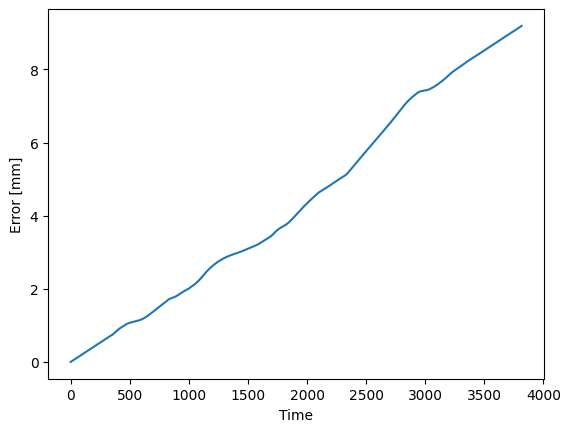

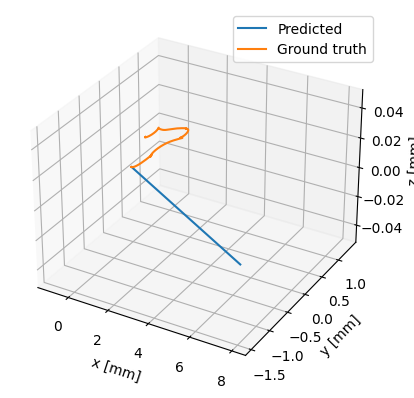

In [8]:

from __future__ import absolute_import, division, print_function
from torch.utils.data import SequentialSampler
from IMU_Pose import IPPU, MinMaxNormalizer
import numpy as np
import torch
from RosbagDatasets import ROSbagIMUGT
import matplotlib.pyplot as plt
import pickle

IMU_SEQUENCE_LENGTH = 10


def translation_from_parameters(params):
    tvec = torch.zeros((2, 1), device=params.device)
    tvec[[0]] = torch.cos(params[0, 1])*params[0, 0]
    tvec[[1]] = torch.sin(params[0, 1])*params[0, 0]
    return tvec


def evaluate_trajectories(model, dataloader, device):
    print("-> Computing pose predictions")
    with torch.no_grad():
        pred_tvec = []
        gt_tvec = []
        running_loss = 0
        for i, data in enumerate(dataloader, 0):
            imu_data = data[1]
            imu_data = imu_data.to(device, torch.float64)
            gt_delta = data[0]
            gt_delta = gt_delta.to(device)

            outputs = model(imu_data)

            # check if we need to undo a normalization
            if dataloader.dataset.normalizer:
                outputs = dataloader.dataset.normalizer.inverse_transform(outputs, dataloader.dataset.normalizer.transform_dict['dist_angle'])
                gt_delta = dataloader.dataset.normalizer.inverse_transform(gt_delta, dataloader.dataset.normalizer.transform_dict['dist_angle'])

            pred = translation_from_parameters(outputs)
            gt = translation_from_parameters(gt_delta)
            pred_tvec.append(torch.squeeze(pred).cpu().numpy())
            gt_tvec.append(torch.squeeze(gt).cpu().numpy())

    trajectory = np.cumsum(pred_tvec, axis=0)
    gt_trajectory = np.cumsum(gt_tvec, axis=0)

    # compute MSE along trajectory and plot
    traj_error = np.sqrt(np.sum(np.square(trajectory - gt_trajectory), axis=1))
    plt.figure()
    plt.plot(traj_error)
    plt.ylabel('Error [mm]')
    plt.xlabel('Time')
    plt.show()

    # now print data
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    xs = [x[0] for x in trajectory]
    ys = [x[1] for x in trajectory]
    gt_xs = [x[0] for x in gt_trajectory]
    gt_ys = [x[1] for x in gt_trajectory]
    ax.plot(xs, ys, label='Predicted')
    ax.plot(gt_xs, gt_ys, label='Ground truth')
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    ax.set_zlabel('z [mm]')
    plt.legend()
    plt.show()
    # max(this_pose)


if __name__ == '__main__':
    # define model file and bag file with test trajectory
    model_file = 'outputs/IPPU_13Feb2024_163732.ptm'
    test_file = 'runs/test.bag'
    normalizer_file = 'outputs/MinMaxNormalizer_13Feb2024_161453.pkl'

    # initialize model
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    model = IPPU2()
    model.to(device)
    model.load_state_dict(torch.load(model_file, map_location=device))
    model.eval()

    # initialize test trajectory sequentially
    testset = ROSbagIMUGT(test_file, "/imu", "/gazebo/model_states", imu_seq_length=IMU_SEQUENCE_LENGTH)

    if normalizer_file != None:
        normalizer = pickle.load(open(normalizer_file, 'rb'))
        testset.normalizer = normalizer

    testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                             shuffle=False, drop_last=False, num_workers=0)

    # evaluate and plot trajectory compared to ground truth
    evaluate_trajectories(model, testloader, device)